In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import copy


In [85]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

Using device:  cuda


In [86]:
BASE_DIR = "../Datasets/AlzheimerDataset/"
TRAIN_DIR = os.path.join(BASE_DIR, 'OriginalDataset')

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 4
LEARNING_RATE = 0.001

In [87]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),           # Increased from 15
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),         # NEW: vertical flip
    transforms.RandomAffine(0, translate=(0.15, 0.15), scale=(0.9, 1.1)),  # Enhanced
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),  # Enhanced
    transforms.RandomGrayscale(p=0.1),       # NEW: occasional grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   
                        std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(TRAIN_DIR)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset.dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset.dataset = datasets.ImageFolder(TRAIN_DIR, transform=val_transform)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

class_names = full_dataset.classes
print(f"\nClasses found: {class_names}")
print(f"Total training images: {len(train_dataset)}")
print(f"Total validation images: {len(val_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}\n")




Classes found: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Total training images: 5120
Total validation images: 1280
Number of training batches: 160
Number of validation batches: 40



In [ ]:
import torchvision.models as models

print("="*60)
print("Loading Pre-trained ResNet50 Model")
print("="*60)

model = models.resnet50(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

# Replace the classifier
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_CLASSES)
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}\n")

print("="*60)
print("MODEL ARCHITECTURE (Classifier Only)")
print("="*60)
print(model.fc)
print("="*60 + "\n")

Loading Pre-trained ResNet50 Model


d:\AKASH\PROJECTS\Multi_DL_Model\Backend\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AKASH\PROJECTS\Multi_DL_Model\Backend\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Total parameters: 24,033,604
Trainable parameters: 22,588,676
Frozen parameters: 1,444,928

MODEL ARCHITECTURE (Classifier Only)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=256, out_features=4, bias=True)
)



In [89]:
criterion = nn.CrossEntropyLoss()

# Only optimize parameters that require gradients
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                       lr=LEARNING_RATE)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

In [90]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training', leave=False)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [91]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(val_loader, desc='Validation', leave=False)

    with torch.no_grad():
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [92]:
print("="*60)
print("STARTING TRAINING WITH TRANSFER LEARNING")
print("="*60 + "\n")

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
patience_counter = 0
patience = 5

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-"*40)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.6f}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_alzheimer_resnet50.pth')
        print(f"✓ New best model saved! (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{patience})")
    
    if patience_counter >= patience:
        print(f"\n✓ Early stopping triggered after {epoch+1} epochs")
        break

model.load_state_dict(best_model_wts)
print(f"\n{'='*60}")
print(f"TRAINING COMPLETE!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"{'='*60}\n")


STARTING TRAINING WITH TRANSFER LEARNING


Epoch 1/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.9468 | Train Acc: 53.93%
Val Loss:   0.8770 | Val Acc:   57.27%
✓ New best model saved! (Val Acc: 57.27%)

Epoch 2/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.8750 | Train Acc: 56.76%
Val Loss:   0.9207 | Val Acc:   55.47%
No improvement (1/5)

Epoch 3/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.8526 | Train Acc: 57.25%
Val Loss:   1.0567 | Val Acc:   44.22%
No improvement (2/5)

Epoch 4/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.8373 | Train Acc: 59.34%
Val Loss:   0.9510 | Val Acc:   51.33%
No improvement (3/5)

Epoch 5/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.8241 | Train Acc: 59.92%
Val Loss:   0.9156 | Val Acc:   53.75%
No improvement (4/5)

Epoch 6/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.8169 | Train Acc: 59.71%
Val Loss:   0.7977 | Val Acc:   59.45%
✓ New best model saved! (Val Acc: 59.45%)

Epoch 7/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.8116 | Train Acc: 60.39%
Val Loss:   0.8000 | Val Acc:   59.30%
No improvement (1/5)

Epoch 8/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.8027 | Train Acc: 61.35%
Val Loss:   0.7678 | Val Acc:   59.92%
✓ New best model saved! (Val Acc: 59.92%)

Epoch 9/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7994 | Train Acc: 61.45%
Val Loss:   0.8595 | Val Acc:   57.19%
No improvement (1/5)

Epoch 10/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7912 | Train Acc: 61.39%
Val Loss:   0.7524 | Val Acc:   63.67%
✓ New best model saved! (Val Acc: 63.67%)

Epoch 11/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7893 | Train Acc: 62.32%
Val Loss:   0.9389 | Val Acc:   60.31%
No improvement (1/5)

Epoch 12/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7787 | Train Acc: 62.44%
Val Loss:   0.7520 | Val Acc:   63.36%
No improvement (2/5)

Epoch 13/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7606 | Train Acc: 64.20%
Val Loss:   0.7771 | Val Acc:   61.17%
No improvement (3/5)

Epoch 14/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7644 | Train Acc: 63.98%
Val Loss:   0.8823 | Val Acc:   56.48%
No improvement (4/5)

Epoch 15/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7572 | Train Acc: 64.67%
Val Loss:   0.7520 | Val Acc:   63.98%
✓ New best model saved! (Val Acc: 63.98%)

Epoch 16/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7510 | Train Acc: 64.73%
Val Loss:   0.9598 | Val Acc:   54.14%
No improvement (1/5)

Epoch 17/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7392 | Train Acc: 65.39%
Val Loss:   0.9331 | Val Acc:   55.16%
No improvement (2/5)

Epoch 18/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7388 | Train Acc: 66.35%
Val Loss:   0.7136 | Val Acc:   66.56%
✓ New best model saved! (Val Acc: 66.56%)

Epoch 19/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7257 | Train Acc: 67.13%
Val Loss:   0.7599 | Val Acc:   64.61%
No improvement (1/5)

Epoch 20/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7191 | Train Acc: 66.97%
Val Loss:   0.7132 | Val Acc:   64.06%
No improvement (2/5)

Epoch 21/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7042 | Train Acc: 68.16%
Val Loss:   0.7151 | Val Acc:   67.73%
✓ New best model saved! (Val Acc: 67.73%)

Epoch 22/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7074 | Train Acc: 67.25%
Val Loss:   0.6666 | Val Acc:   68.59%
✓ New best model saved! (Val Acc: 68.59%)

Epoch 23/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.7031 | Train Acc: 68.24%
Val Loss:   0.7750 | Val Acc:   61.95%
No improvement (1/5)

Epoch 24/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.6894 | Train Acc: 68.83%
Val Loss:   0.6899 | Val Acc:   67.11%
No improvement (2/5)

Epoch 25/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.6876 | Train Acc: 68.75%
Val Loss:   0.6382 | Val Acc:   70.86%
✓ New best model saved! (Val Acc: 70.86%)

Epoch 26/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.6648 | Train Acc: 69.82%
Val Loss:   0.7380 | Val Acc:   66.88%
No improvement (1/5)

Epoch 27/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.6649 | Train Acc: 70.08%
Val Loss:   0.7741 | Val Acc:   65.08%
No improvement (2/5)

Epoch 28/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.6632 | Train Acc: 70.25%
Val Loss:   0.6322 | Val Acc:   70.94%
✓ New best model saved! (Val Acc: 70.94%)

Epoch 29/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.6446 | Train Acc: 71.05%
Val Loss:   0.6330 | Val Acc:   71.64%
✓ New best model saved! (Val Acc: 71.64%)

Epoch 30/30
----------------------------------------
Learning Rate: 0.001000


Train Loss: 0.6348 | Train Acc: 71.89%
Val Loss:   0.7037 | Val Acc:   67.81%
No improvement (1/5)

TRAINING COMPLETE!
Best Validation Accuracy: 71.64%



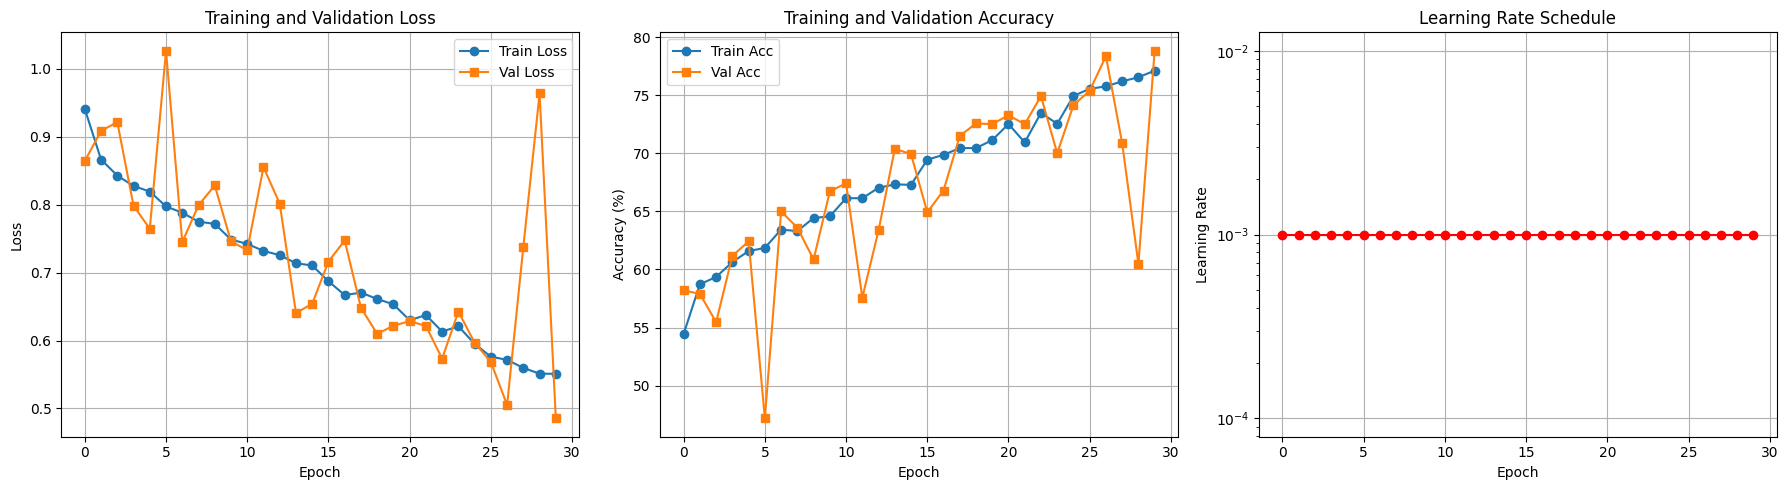

Training plots saved as 'training_history_resnet50.png'


In [82]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# Learning rate plot
axes[2].plot(history['lr'], color='red', marker='o')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('training_history_resnet50.png', dpi=300)
plt.show()

print("Training plots saved as 'training_history_resnet50.png'")

In [83]:
# Save the entire model (architecture + weights + optimizer + everything)
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
    'best_val_acc': best_val_acc,
    'history': history,
    'class_names': class_names,
    'model_architecture': str(model)  # Save model structure info
}, 'best_alzheimer_model_complete.pth')

print("✓ Complete model saved as 'best_alzheimer_model_complete.pth'")

✓ Complete model saved as 'best_alzheimer_model_complete.pth'
